In [1]:
import numpy as np
import scipy.signal
import scipy.stats
import tensorflow as tf
import matplotlib.pyplot as plt

from latent_dynamics import *
from variational import *
from normalizing_flow import *

from tqdm import tqdm

In [2]:
def DynamicMultiLayerPerceptron(x, in_dim, out_dim, time, gather=True):
    n_input = x.shape[0].value
    x_expand = tf.reshape(x, [time * n_input, in_dim])
    output_expand = MultiLayerPerceptron(
        x_expand, layers=[256, 256, out_dim]).get_output_layer()
    if gather:
        output_gather = tf.reshape(output_expand, [n_input, time * out_dim])
        return output_gather
    else:
        return x_expand

In [3]:
class DynamicalSystemVisualizer(object):

    def __init__(self, dim, time_steps):
        """Sets up the visualizer object.

        Parameters:
        -----------
        dim: int
            Dimensionality of the observation.
        time_steps: int
            Number of time steps in the dynamical system.
        """
        self.n_times = time_steps
        # Properties of latent and observation
        # Spaces.
        self.dim = dim
        self.set_up_figures()

    def set_up_figures(self):
        self.fig, self.ax = plt.subplots(1, self.dim + 1)
        self.fig.set_size_inches(5 * (self.dim + 1), 5)
        self.ctr = 0
        for i in range(self.dim):
            self.ax[i].set_xlabel('Time')
            self.ax[i].set_ylabel('Dim {}'.format(i + 1))
        self.ax[self.dim].set_xlabel('Dim 1')
        self.ax[self.dim].set_ylabel('Dim 2')

    def add_trajectory(self, trajectory, color, alpha=1.):
        """Adds a trajectory to the trajectories to be visualized."""
        if len(trajectory.shape) == 1:
            trajectory = trajectory[np.newaxis, :]
        shape = trajectory.shape
        if shape[1] == self.n_times * self.dim:
            for d in range(self.dim):
                sample = trajectory[:, d::self.dim]
                self.ax[d].plot(sample.T, color=color, alpha=alpha)
            for i in range(shape[0]):
                self.ax[self.dim].plot(
                    trajectory[i, ::self.dim], trajectory[i, 1::self.dim], color=color, alpha=alpha)

-0.15999999999999998


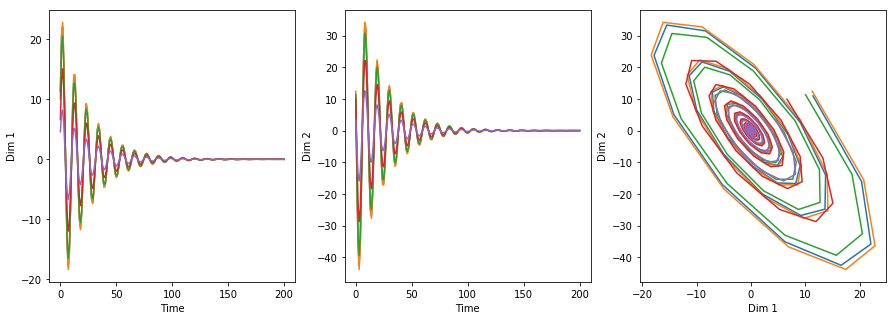

In [4]:
TRANS_MATRIX = np.array([[.1, -.4], [.1, -.2]])
TRANS_MATRIX = np.array([[.1, -.4], [.1, -.2]]) * 4
#TRANS_MATRIX = np.array([[.25, .5], [.5, .25]])

time_ = 200

print np.power(np.trace(TRANS_MATRIX), 2) - np.linalg.det(TRANS_MATRIX) # Determinse the stability of the dynamics

def lin_dyn(x_not, t_mat, time, dt=0.001):
    l = [x_not]
    for i in range(time):
        l.append(l[-1] + np.matmul(l[-1], t_mat))
    return np.squeeze(np.array(l))

lin_vis = DynamicalSystemVisualizer(dim=2, time_steps=time_+1)
for i in range(5):
    init_point = np.random.normal(10, 3, 2)
    l = lin_dyn(init_point, TRANS_MATRIX, time_, dt=0.001)
    lin_vis.add_trajectory(l.flatten(), color='C{}'.format(i))

In [5]:
L = 10 # Number of samples for monte carlo estimate
N = 100
LAT_DIM = 2
OBS_DIM = 3
TIME = 10

In [6]:
with tf.Graph().as_default():
    t1 = Transform(LAT_DIM, LAT_DIM, initial_value=TRANS_MATRIX + np.eye(2))
    trans = ConditionalRandomVariable(
        dim_x=LAT_DIM, dim_y=LAT_DIM, transform=t1, noise=2)
    t2 = Transform(LAT_DIM, OBS_DIM, initial_value=np.array([[1., 2., 1.], [2., 1., 1.]]))
    emmit = ConditionalRandomVariable(
        dim_x=OBS_DIM, dim_y=LAT_DIM, transform=t2, noise=2)
    seq = MarkovLatentDynamics(trans, emmit, TIME)
    samp = seq.sample(N)
    prob = seq.log_prob(samp[0], samp[1])
    print samp[0].shape, samp[1].shape
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        z_star, x_star = sess.run(samp)
        p = sess.run(prob)

(100, 20) (100, 30)


In [7]:
print p
print x_star.shape
print z_star.shape

[29.48665862 30.45498126 22.97544414 35.69047535 19.47509082 21.29804815
 30.570386   23.61489594 28.16511371 26.15309031 22.14613834 25.06489745
 27.1853434  32.62123203 30.60136688 26.38254241 25.2671709  27.42749588
 28.86316866 32.54904614 21.01587379 31.6221415  37.11060718 25.16658924
 35.25580335 26.32677269 33.08255641 21.39704747 28.85344915 25.33999814
 30.71364868 31.91660635 20.98616774 34.41013417 20.44978669 21.19888511
 24.41253442 23.95238299 25.26365289 34.11031649 28.16069596 35.99474949
 19.52459228 28.97192392 21.61709772 25.5280575  25.23524705 25.41184824
 27.72041385 20.38835931 27.6863183  19.45047383 34.69306719 31.5721269
 26.62318577 33.89821407 29.70481552 20.85279799 27.28706382 27.62587967
 28.9409624  34.92029495 25.16885267 30.44778513 24.30793914 23.64501374
 39.03678775 24.32709385 22.00610118 28.57533436 22.03261826 30.52698735
 33.20718621 22.53645329 28.39237252 23.7203192  29.50760076 33.11838934
 30.95779986 31.07144257 29.74365504 27.05428697 31.

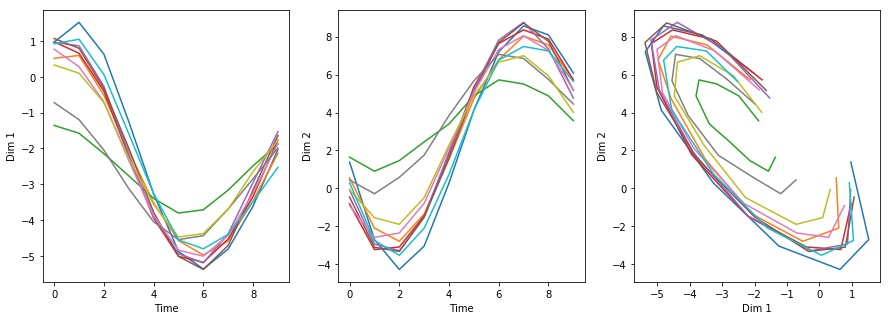

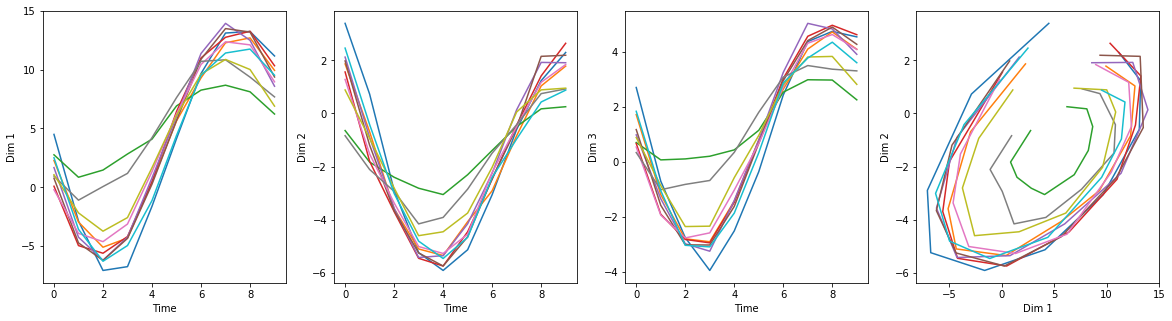

In [8]:
lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
for i in range(L):
    lin_vis_lat.add_trajectory(z_star[i, :], color='C{}'.format(i))

lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
for i in range(L):
    lin_vis_obs.add_trajectory(x_star[i, :], color='C{}'.format(i))

# Building Graph for Elbo Computation and Minimization

In [9]:
graph = tf.Graph()
tot_iterations = 0

with graph.as_default():

    # Observation
    x = tf.placeholder(shape=[1, OBS_DIM * TIME], dtype=tf.float64, name='input')

    # Variational Model
    rec = DynaFlowConditionalRandomVariable(y=x, dim=LAT_DIM, time=TIME, num_layers=5)

    # Generative Model
    # Transition Transformation
    # The following basically is the model for a kalman filter
    # with diagonal covariances
    t1 = Transform(LAT_DIM, LAT_DIM, initial_value=np.array([[1., .1], [.1, 1.]]))
    trans = ConditionalRandomVariable(
        dim_x=LAT_DIM, dim_y=LAT_DIM, transform=t1)
    # Emmision Transformation
    t2 = Transform(LAT_DIM, OBS_DIM)
    emmit = ConditionalRandomVariable(dim_x=OBS_DIM, dim_y=LAT_DIM, transform=t2)
    gen = MarkovLatentDynamics(trans, emmit, TIME)

    # Sample from variational for monte carlo
    sample, log_q = rec.sample_log_prob(10)

    print gen.log_prob(sample, x).shape, log_q.shape
    loss = - tf.reduce_sum(gen.log_prob(sample, x)) + tf.reduce_sum(log_q)

    # Set up the learning algorithm
    train_op = tf.train.AdagradOptimizer(learning_rate=.01).minimize(loss)
    #train_op = tf.train.AdamOptimizer(learning_rate=.1).minimize(loss)

    z_d, x_d = gen.sample(L)
    x_hat = gen.sample_observations(n_samples=20, z=sample)

    losses = []
    # Learning
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

(10,) (10,)


# Training The Models

In [10]:
STEPS = 20000

with graph.as_default():
    for i in tqdm(range(STEPS)):
        idx = i % N
        l, _ = sess.run(
            [loss, train_op],
            feed_dict={"input:0": x_star[np.newaxis, idx, :]})
        losses.append(l)
        tot_iterations += 1

100%|██████████| 20000/20000 [12:15<00:00, 27.21it/s]


# Let's Compute the Current Latent Paths and Reconstructions

In [14]:
outputs = []
with graph.as_default():
    for i in tqdm(range(N)):
        rec_, z_i, x_i, x_h = sess.run(
            [sample, z_d, x_d, x_hat],
            feed_dict={"input:0": x_star[np.newaxis, i, :]})
        outputs.append([rec_, z_i, x_i, x_h])

100%|██████████| 100/100 [00:01<00:00, 55.09it/s]


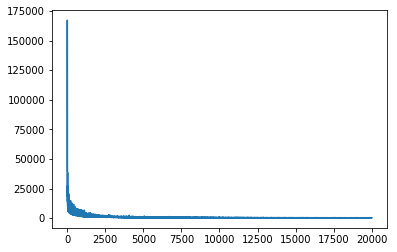

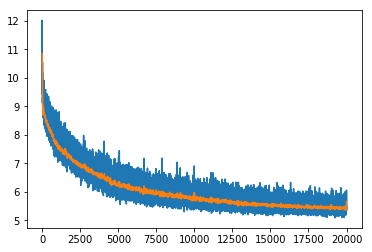

In [15]:
def smooth(x):
    return scipy.signal.savgol_filter(x, window_length=101, polyorder=3)

plt.plot(losses)
plt.show()

plt.plot(np.log(np.array(losses)))
plt.plot(np.log(np.array(smooth(losses))))
plt.show()

In [16]:
recs_ = np.squeeze(np.array([e[0] for e in outputs])[:, 0, :])
z_draw = np.squeeze(np.array([e[1] for e in outputs])[:, 0, :])
x_draw = np.squeeze(np.array([e[2] for e in outputs])[:, 0, :])

print recs_.shape, z_draw.shape, x_draw.shape

(100, 20) (100, 20) (100, 30)


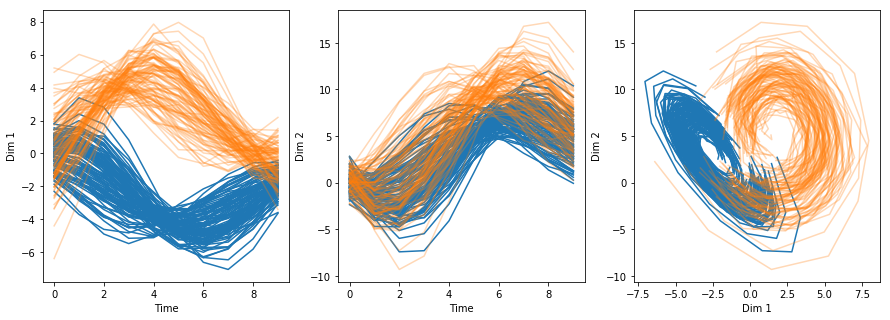

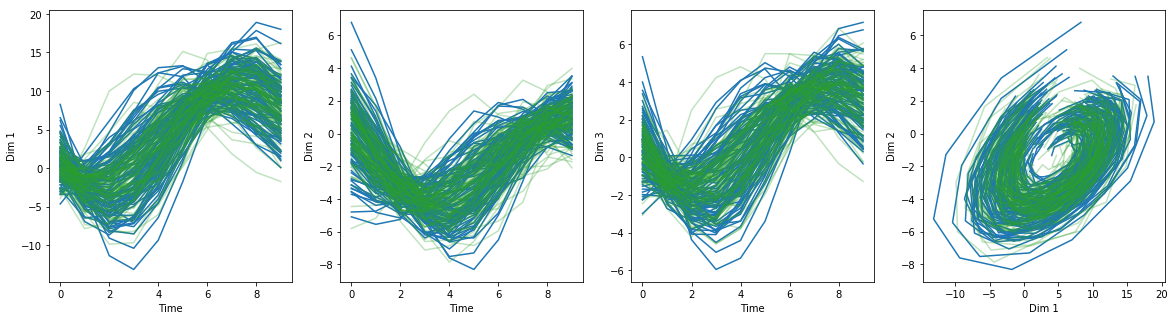

In [17]:
lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
lin_vis_lat.add_trajectory(z_star[:, :], color='C0')
lin_vis_lat.add_trajectory(recs_, color='C1', alpha=0.3)
#lin_vis_lat.add_trajectory(np.squeeze(z_draw), color='C2', alpha=0.1)

lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
lin_vis_obs.add_trajectory(x_star[:, :], color='C0')
lin_vis_obs.add_trajectory(np.squeeze(x_draw), color='C2', alpha=0.3)

# Individual Paths, their Codes and Reconstructions

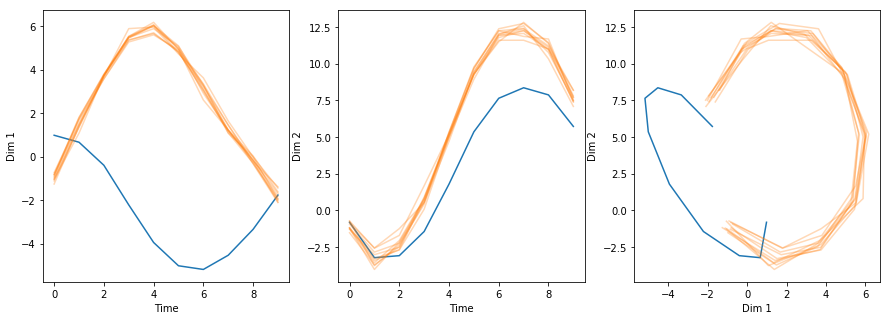

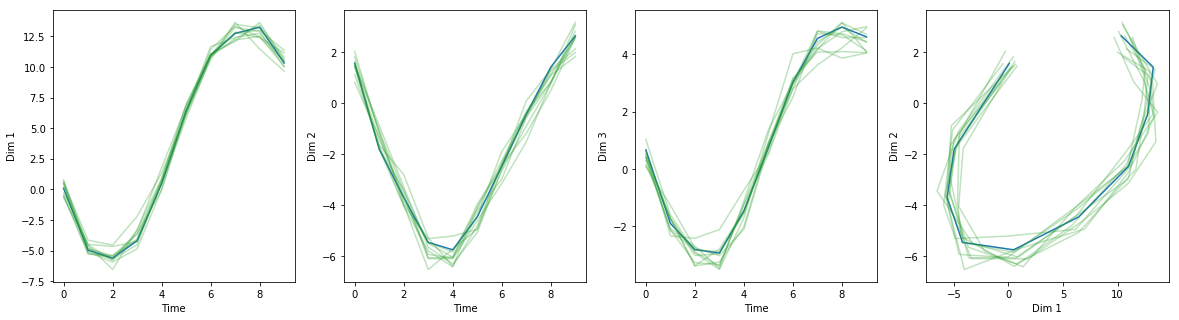

In [28]:
sample_idx = 3

z_h_ = np.squeeze(np.array([e[0] for e in outputs])[sample_idx, :, :])
x_h_ = np.squeeze(np.array([e[3] for e in outputs])[sample_idx, :, :])

lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
lin_vis_lat.add_trajectory(z_star[sample_idx:sample_idx + 1, :], color='C0')
lin_vis_lat.add_trajectory(z_h_, color='C1', alpha=0.3)
#lin_vis_lat.add_trajectory(np.squeeze(z_draw), color='C2', alpha=0.1)

lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
lin_vis_obs.add_trajectory(x_star[sample_idx:sample_idx + 1, :], color='C0')
lin_vis_obs.add_trajectory(np.squeeze(x_h_), color='C2', alpha=0.3)

In [26]:
sess.close()